In [1]:
#!/bin/env python3

from argparse import ArgumentParser
from ast import Str

import numpy as np
from math import comb
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt
import random
import time
import warnings

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D


# wrapper for pylab, designed to do statistical plots using pandas dataframe 

from scipy.stats import beta, gaussian_kde


import sys
sys.path.append('/home/kblum/local/pism/sources/pism-emulator/')

from pismemulator.utils import param_keys_dict as keys_dict
from pismemulator.utils import kl_divergence
from pismemulator.kyle_utils import *

import seaborn as sns



In [2]:
#def plot_multiple_groups(dfs,vars,data_group_things):
#    # df : data frame of all models for true avg
#    # vars: list of variable (column) names
#    # models: list of available models (0,1,2 ...)
#    # num_groups: number of ensembles
#    # per_group: number of emulators per ensemble
#
#    sns.set_theme(palette='colorblind')
#    rows = int(np.ceil(len(vars)/2))
#    cols = 2
#
#    fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
#
#    groups = []
#    
#    foo = 0
#    bar = 0
#    for i in range(rows):
#        for j in range (cols):            
#            var = vars[foo]
#            print(var)
#            for count, df in enumerate(dfs):
#                sns.kdeplot(data=df,x=var,ax=axes[int(i),int(j)],label=data_group_things[count]) # remove y axis values, add x axis label
#                axes[i,j].set(xlabel=keys_dict[var],yticklabels=[],ylabel=None)
#            axes[int(i),int(j)].legend()
#            foo += 1
#
#def kl_divergences(df,vars,models,num_groups=10,per_group=60):
#    # df : data frame of all models for true avg
#    # vars: list of variable (column) names
#    # models: list of available models (0,1,2 ...)
#    # num_groups: number of ensembles
#    # per_group: number of emulators per ensemble
#
#    divs = {}
#    groups = []
#
#    random.seed(8675309)
#    for i in range(num_groups):
#        groups.append(random.sample(sorted(models),per_group))
#    
#    bar = 0
#    for i in range(len(vars)):
#        kl_average = 0
#        var = vars[i]
#        p = np.histogram(df[var], bins=30,density=True)[0]
#        for group in groups:
#            temp = df[df['Model'].isin(group)]
#            q = np.histogram(temp[var],bins=30,density=True)[0]
#            kl_average += np.abs(kl_divergence(p,q))
#        kl_average  = kl_average / num_groups
#        divs[var] = kl_average
#    return divs

In [3]:
emulator_dirs = []
clever_var_name = [250,500,750,1000]
for i in clever_var_name:
    emulator_dir = f"/data/work/antarctica_calibration/speedemulator/emulator_dirs/pp_50m_{i}t_1000e"
    emulator_dirs.append(emulator_dir)
# emulator_dirs.append(2021_11_pseudo_plastic_kb)
samples_file = "/data/work/antarctica_calibration/speed_calibration_pseudo_plastic_128.csv"
frac         = 0.1

print("Loading prior samples\n")
samples = pd.read_csv(samples_file).drop(columns=["id"])

X = samples.values
X_keys = samples.keys()
#n_samples, n_parameters = X.shape

#l_post = []


Loading prior samples



In [4]:
posterior_dfs = []
models_list = []
for emulator_dir in emulator_dirs:
        
    X_list = []
    
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        #print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=1)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    # Very janky, going to need to stop getting variables from file names at some point
    training = emulator_dir.split("_")[4].split("t")[0]
    print(training)
    print(f"Merging posteriors into dataframe")

    posterior_df = pd.concat(X_list)
    posterior_df["Training"] = int(training)
    
    print(training)
    posterior_dfs.append(posterior_df)
    #X_posterior = posterior_df.drop(columns=["Model"]).values
    models = posterior_df['Model'].unique()
    models_list.append(models)


Loading posterior samples

250
Merging posteriors into dataframe
250
Loading posterior samples

500
Merging posteriors into dataframe
500
Loading posterior samples

750
Merging posteriors into dataframe
750
Loading posterior samples

1000
Merging posteriors into dataframe
1000


In [5]:
#print(len(posterior_dfs[0]))
for i in range(4):
    print(len(posterior_dfs[i]))

4755050
4950050
4950050
4933050


In [7]:
np.seterr(invalid='ignore',divide='ignore')
lcurves = {}
count = 0
for foo in posterior_dfs:
    lcurves[clever_var_name[count]] = (kl_deviation(foo,X_keys,models))
    count+=1

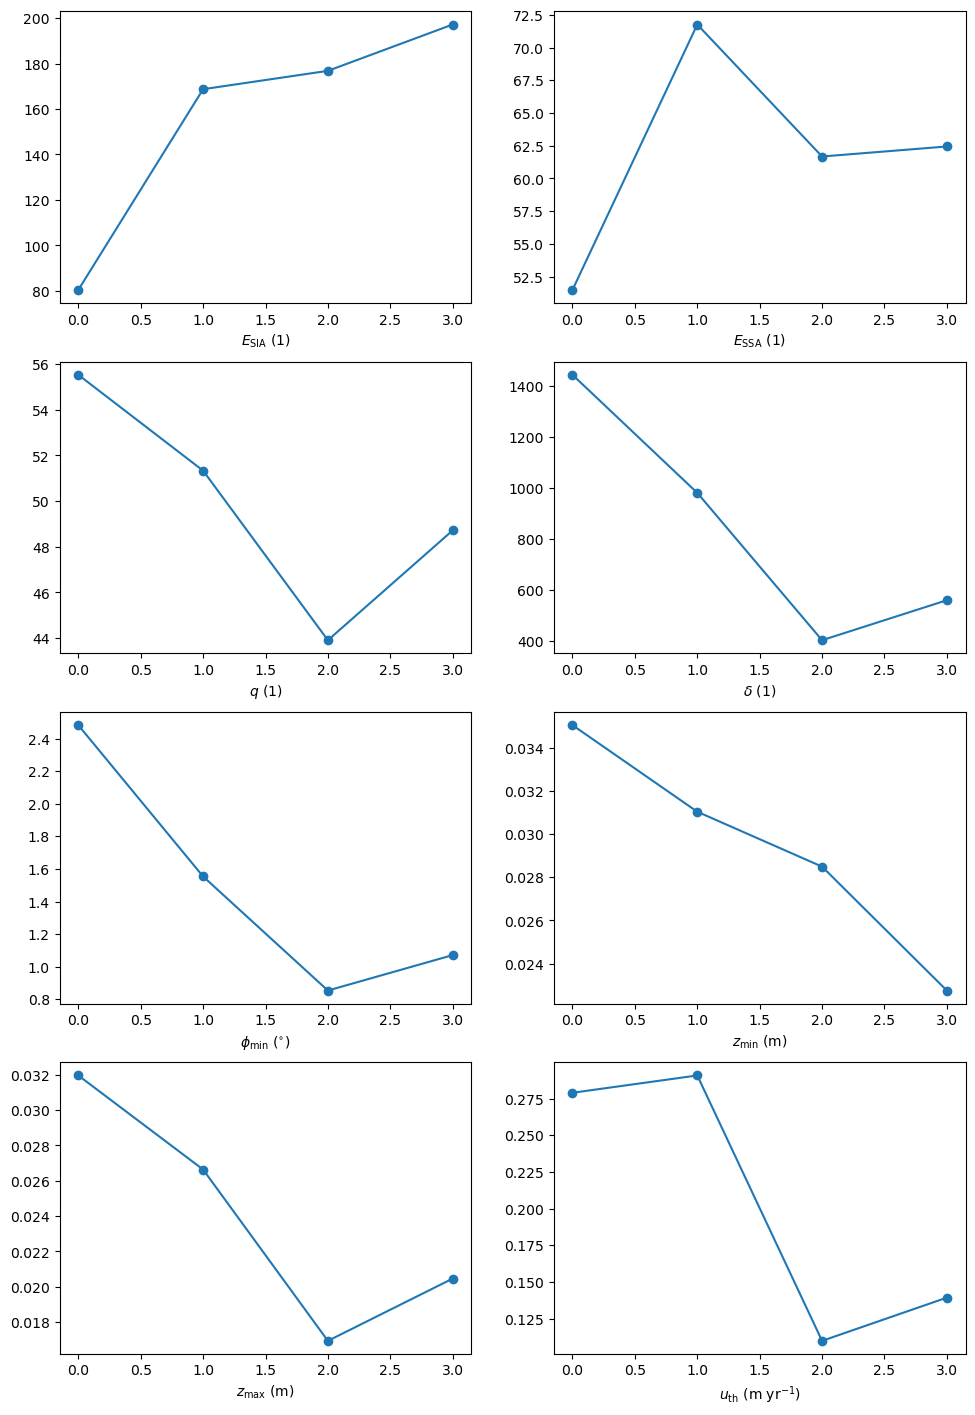

In [17]:
rows = int(np.ceil(len(X_keys)/2))
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
foo = 0

for i in range(rows):
    for j in range (cols):
        var = X_keys[foo]
        xs = range(len(clever_var_name))
        ys = []
        
        for bar in clever_var_name:
            ys.append(lcurves[bar][var])
        foo += 1
        
        axes[i,j].plot(xs,ys,'o-')
        axes[i,j].set(xlabel=keys_dict[var])

1
2
3
4


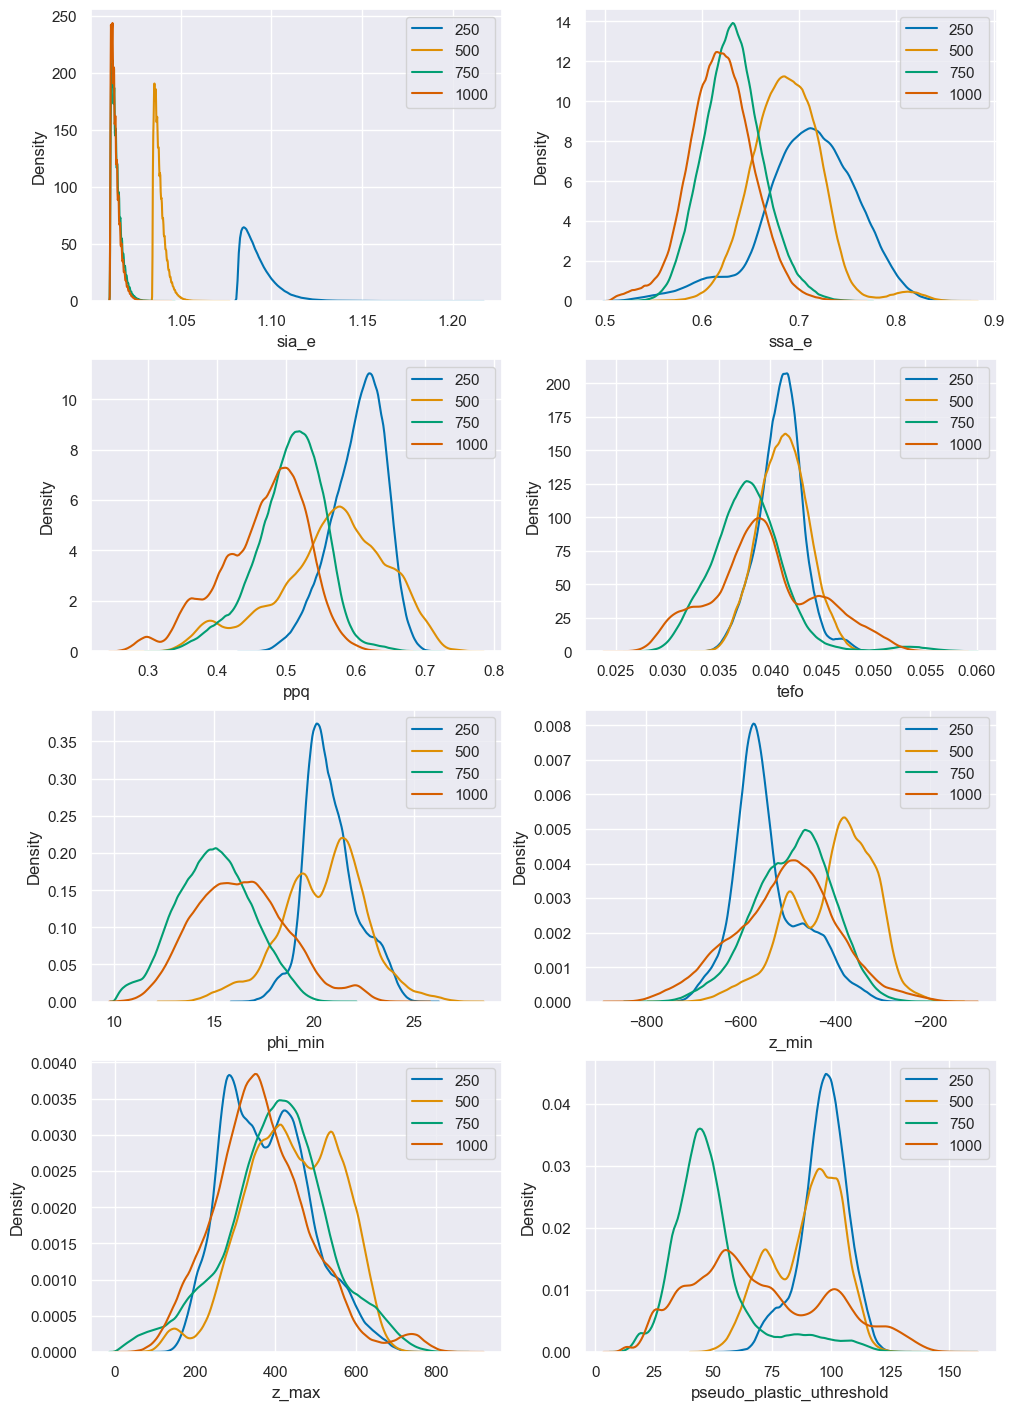

In [4]:
plot_posteriors(posterior_dfs, X_keys,labels=clever_var_name) 

In [ ]:
#plot_multiple_groups(posterior_dfs, X_keys, clever_var_name)
#sns.kdeplot(data=posterior_dfs, x=var,ax=axes[i,j],color='black')

In [ ]:
np.seterr(invalid='ignore',divide='ignore')
lcurves = {}
xs = np.linspace(5,200,40)
for per_group in xs:
    print(per_group)
    lcurves[per_group] = kl_divergences(posterior_df, X_keys, models, per_group=int(per_group),num_groups=20)

In [ ]:
rows = int(np.ceil(len(X_keys)/2))
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
foo = 0

for i in range(rows):
    for j in range (cols):
        var = X_keys[foo]
        foo += 1
        ys = []
        for bar in xs:
            ys.append(lcurves[bar][var])
        
        axes[i,j].plot(xs,ys,'k.-')
        axes[i,j].set(xlabel=keys_dict[var],yticklabels=[],ylabel=None)


In [ ]:
#print(plot_groups(posterior_df, X_keys, models, per_group=15))
for pergroup in [15,50,100]:
    print(kl_divergences(posterior_df, X_keys, models, per_group=int(pergroup),num_groups=20)['ppq'])